In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=100

In [3]:
data = tf.keras.utils.image_dataset_from_directory('D:\Skripsi\Dataset',
                                                   seed=123,
                                                   shuffle=True,
                                                   image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE)

Found 3872 files belonging to 8 classes.


In [4]:
class_names = data.class_names
class_names

['Bacterial blight',
 'Cercospora Leaf blight',
 'Downy mildew',
 'Frogeye',
 'Healthy',
 'Potassium Deficiency',
 'Rust',
 'Target Spot']

In [5]:
for image_batch, labels_batch in data.take(1):
    print(image_batch.dtype())
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 5 7 5 2 1 7 6 7 7 3 2 3 6 5 5 7 2 7 5 3 0 2 7 2 2 6 3 6 2 6 2]


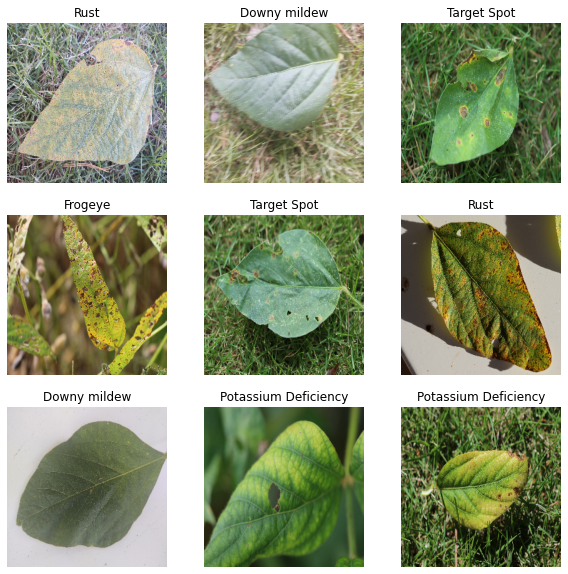

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data)

In [9]:
len(train_ds)

96

In [10]:
len(val_ds)

12

In [11]:
len(test_ds)

13

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 64)        1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100
96/96 [==============================] - 1478s 11s/step - loss: 1.9582 - accuracy: 0.2249 - val_loss: 1.7307 - val_accuracy: 0.3333
Epoch 2/100
96/96 [==============================] - 554s 6s/step - loss: 1.5709 - accuracy: 0.3919 - val_loss: 1.6001 - val_accuracy: 0.3828
Epoch 3/100
96/96 [==============================] - 568s 6s/step - loss: 1.4000 - accuracy: 0.4574 - val_loss: 1.2083 - val_accuracy: 0.5312
Epoch 4/100
96/96 [==============================] - 560s 6s/step - loss: 1.1974 - accuracy: 0.5329 - val_loss: 0.9273 - val_accuracy: 0.6536
Epoch 5/100
96/96 [==============================] - 582s 6s/step - loss: 0.9409 - accuracy: 0.6488 - val_loss: 0.8071 - val_accuracy: 0.6927
Epoch 6/100
96/96 [==============================] - 578s 6s/step - loss: 0.8539 - accuracy: 0.6784 - val_loss: 0.7289 - val_accuracy: 0.7214
Epoch 7/100
96/96 [==============================] - 523s 5s/step - loss: 0.7927 - accuracy: 0.7077 - val_loss: 0.6371 - val_accuracy: 0.7318
Epoc

In [24]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 405s 1s/step - loss: 0.1136 - accuracy: 0.9639


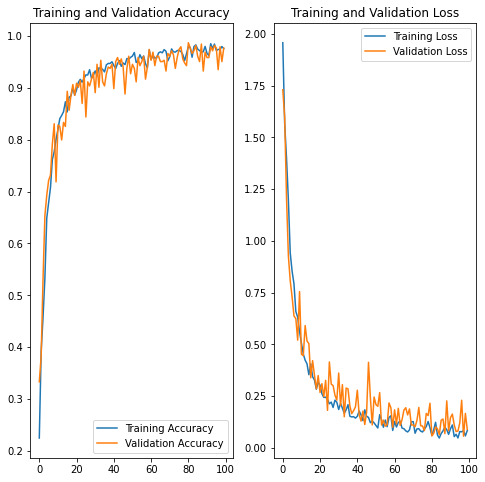

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Frogeye
1/1 [==============================] - 2s 2s/step
predicted label: Frogeye


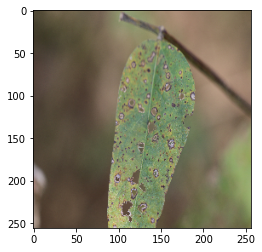

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 68ms/step


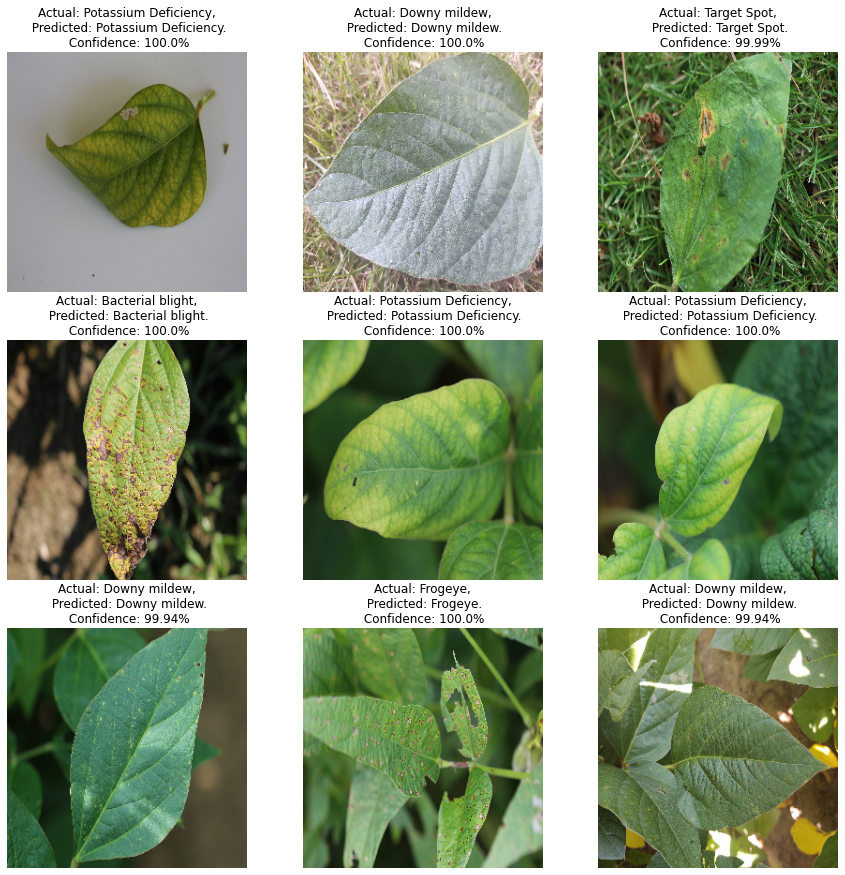

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [29]:
list_test = list(test_ds)
len(list_test)

13

In [30]:
y = np.concatenate([y for x, y in list_test])
x = np.concatenate([x for x, y in list_test])

In [31]:
predictions = model.predict(x)
y_pred = np.argmax(predictions, axis=1)

13/13 [==============================] - 18s 1s/step


In [34]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred, target_names=class_names, digits=4))

                        precision    recall  f1-score   support

      Bacterial blight     0.9508    0.9206    0.9355        63
Cercospora Leaf blight     0.9459    0.9459    0.9459        37
          Downy mildew     0.9783    1.0000    0.9890        45
               Frogeye     0.9091    0.9804    0.9434        51
               Healthy     1.0000    0.9831    0.9915        59
  Potassium Deficiency     1.0000    1.0000    1.0000        61
                  Rust     0.9535    0.9318    0.9425        44
           Target Spot     0.9636    0.9464    0.9550        56

              accuracy                         0.9639       416
             macro avg     0.9627    0.9635    0.9628       416
          weighted avg     0.9644    0.9639    0.9639       416



In [35]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(y, y_pred)
print(CM)
print('\nTest Accuracy: ' + str(np.sum(np.diag(CM)) / np.sum(CM)))

[[58  2  0  2  0  0  1  0]
 [ 1 35  0  0  0  0  0  1]
 [ 0  0 45  0  0  0  0  0]
 [ 1  0  0 50  0  0  0  0]
 [ 0  0  1  0 58  0  0  0]
 [ 0  0  0  0  0 61  0  0]
 [ 1  0  0  1  0  0 41  1]
 [ 0  0  0  2  0  0  1 53]]

Test Accuracy: 0.9639423076923077


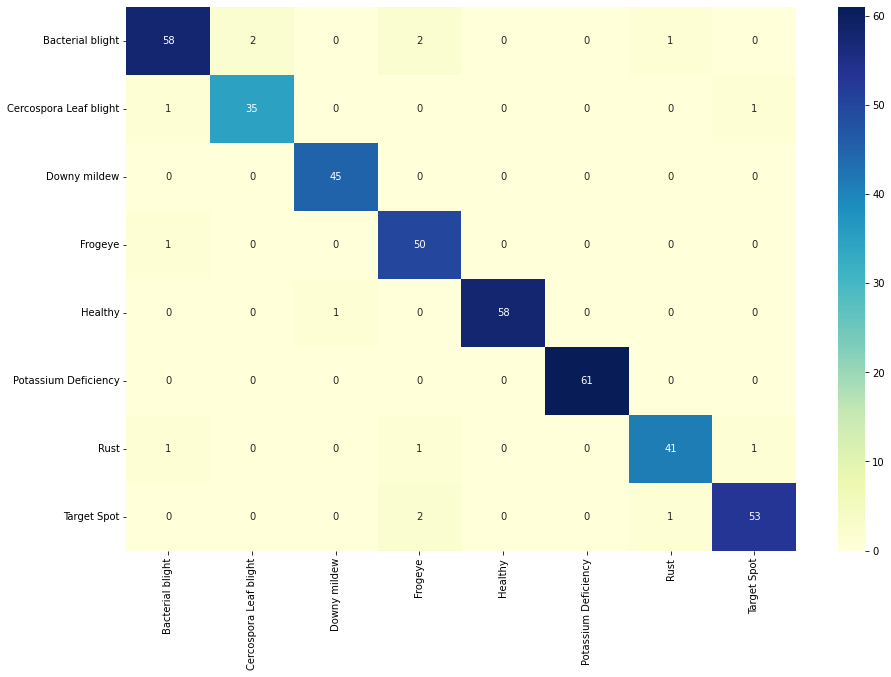

In [36]:
import seaborn
import matplotlib
import matplotlib.pyplot as plt

fig_dims = (15, 10)
fig, ax = plt.subplots(figsize=fig_dims)

seaborn.heatmap(CM, annot=True, ax=ax,fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.show()

In [37]:
import os
model_version=max([int(i) for i in os.listdir("D:\Skripsi\Code\models") + [0]])+1
model.save(f"D:\Skripsi\Code\models/{model_version}")

INFO:tensorflow:Assets written to: D:\Skripsi\Code\models/15\assets


INFO:tensorflow:Assets written to: D:\Skripsi\Code\models/15\assets


In [38]:
model.save("soybean_diseases_v12.h5")